In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.linear_model import LinearRegression

In [103]:
#cargamos los datos
compu = pd.read_csv('computer_repair.csv', index_col = 'Row')
compu = compu[['Minutes', 'Units']]
compu.head(3)

,Minutes,Units
Row,,
1,23,1
2,29,2
3,49,3


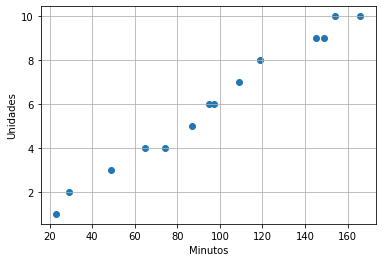

In [104]:
#Dividimos los datos
X = np.array(compu['Minutes'].values).reshape(-1, 1)
y = np.array(compu['Units'].values).reshape(-1, 1)

#graficamos
plt.scatter(X, y)
plt.xlabel('Minutos')
plt.ylabel('Unidades')
plt.grid()
plt.show()

In [105]:
#instanciamos el modelo de regresion simple

X_train = sm.add_constant(X, prepend = True)
modelo = sm.OLS(endog = y, exog = X)
modelo = modelo.fit()
print(modelo.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              5242.
Date:                Sun, 16 Apr 2023   Prob (F-statistic):                    2.48e-18
Time:                        14:07:52   Log-Likelihood:                         -4.3636
No. Observations:                  14   AIC:                                      10.73
Df Residuals:                      13   BIC:                                      11.37
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

C:\Users\PC\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Notamos que el valor que toma el coeficiente de deterinación es $0.998$, lo cual quiere decir que el modelo explica una buena porción de la variabilidad, por lo que el modelo parece funcionar bien.

Además, el p-valor de la estadística F (para probar si $\beta_1 = 0$) vale practicamente 0, por lo que rechazamos $H_0$, es decir, $\beta_1 \not = 0$.

Todo parece funcionar bien, unicamente resta analizar los residuales para ver si el modelo es adecuado.

Primero analizamos el supuesto de que $\varepsilon_i \sim N(0, \sigma^2)$.

El Omnibus test nos ayuda a verificar si dicho supuesto se cumple, pues $H_0$ es los errores se distribuyen de manera normal. El p-valor del Omnibus test es muy grande, $0.9$, por lo que no rechazamos $H_0$, es decir que los errores se distribuyen de manera normal.
Para poder afirmar dicha proposición podemos usar la prueba de Jarque-Bera, pues su p-valor también es grande. Finalmente, también podemos ver el qqplot

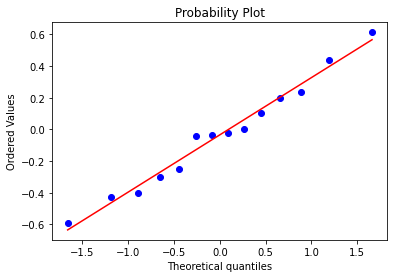

In [106]:
stats.probplot(modelo.resid, dist="norm", plot=plt)
plt.show()

In [107]:
stats.kstest(modelo.resid, stats.norm.cdf)

KstestResult(statistic=0.27655062570054145, pvalue=0.19424835933230888)

In [108]:
stats.anderson(modelo.resid)

AndersonResult(statistic=0.18447423059675927, critical_values=array([0.497, 0.566, 0.68 , 0.793, 0.943]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Como el $p-value$ de la prueba de Kolmogovor es $0.19$. 
Por otro lado, la prueba de Anderson nos da una estadística de $0.184$ y los valores críticos (el segundo vector de resultados) contiene número más grandes que $0.184$, por lo que para ningun nivel de significancia dado (tercer vector de resultados) se rechaza la hipótesis nula. 

Así, con todos estos resultados concluimos que los residuales se distribuyen de manera normal

Prodecemos a verificar el supuesto de que si $i \not = j$, entonces $Cov(\varepsilon_i, \varepsilon_j) = 0$, para ello tenemos la prueba de Durbin-Watson. En este caso la estadística tomó el valor de 1.85, como dicho valor está dentro del intervalo $(1.5, 2.5)$, entonces afirmamos que se cumple dicho supuesto de la covarianza.

Procedemos a verificar la homocedasticidad del modelo por medio del grafíco de los residuales contra las predicciones y usando la prueba de Brewn-Pagan 

[('Lagrange multiplier statistic', 5.312362474400911),
 ('p-value', nan),
 ('f-value', 7.949308654247692),
 ('f p-value', 0.01448024332781)]

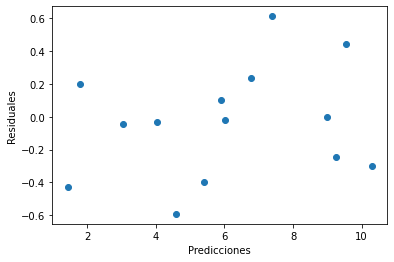

In [109]:
#Predicciones contra residuos (supuesto 3)
predict = modelo.predict(X)
plt.scatter(predict, modelo.resid)
plt.xlabel('Predicciones')
plt.ylabel('Residuales')

names = ['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value']
 
# Get the test result
test_result = sms.het_breuschpagan(modelo.resid, modelo.model.exog)
 
lzip(names, test_result)

Observamos que los puntos no tienen ningun patron. Por último haremos el diagrama de autocorrelación

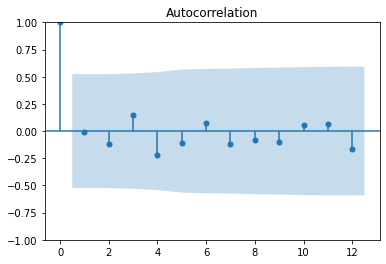

In [110]:
plot_acf(modelo.resid)
plt.show()

Como no hay valores fuera del intervalo de confianza graficado, entonces conlcuimos se cumplen todos los supuestos del modelo y por lo tanto la regresión lineal es adecuada

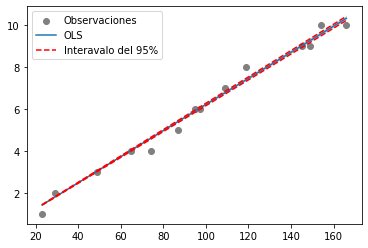

In [111]:
#obtenemos los valores de la regresion
predicciones = modelo.get_prediction(exog = X).summary_frame(alpha=0.5)
predicciones['x'] = X
predicciones['y'] = y
predicciones = predicciones.sort_values('x')

#graficamos las observaciones, la regresion y un intervalo del 95% de confianza
fig, ax = plt.subplots()

ax.scatter(predicciones['x'], predicciones['y'], marker='o', color = "gray", label = 'Observaciones')
ax.plot(predicciones['x'], predicciones["mean"], linestyle='-', label="OLS")
ax.plot(predicciones['x'], predicciones["mean_ci_lower"], linestyle='--', color='red', label="Interavalo del 95%")
ax.plot(predicciones['x'], predicciones["mean_ci_upper"], linestyle='--', color='red')
ax.fill_between(predicciones['x'], predicciones["mean_ci_lower"], predicciones["mean_ci_upper"], alpha=0.3)
ax.legend()

Analizamos gráficamente si los errores tienen distribución normal con media cero

# 5 
Un estudio realizado en una embotelladora de refrescos está analizando la entrega del producto y las operaciones de servicio para maquinas automáticas. Se sospecha que el tiempo que requiere un empleado encargado de entregar refrescos, cargar, dar servicio a una maquina está relacionado con el volúmen entregado. Se monitorean 25 tiendas y se obtienen los resultados desplegados en la tabla refrescos.txt. 

Col 1 =temp = Tiempo de entrega en minutos

Col 2 =time_m =Volmen de entrega en nmero de casos

Ajusta un modelo lineal, verifica el ajuste y los supuestos para determinar si la sospecha es fundamentada.

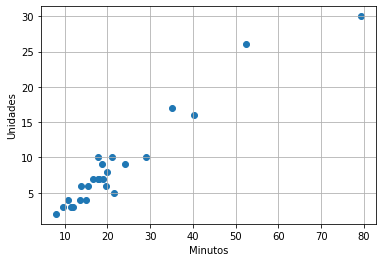

In [112]:
#cargamos los datos
refrescos = pd.read_csv('refrescos.txt', header = None, sep = ' ')
refrescos.head()

#Dividimos los datos
X = np.array(refrescos[0].values).reshape(-1, 1)
y = np.array(refrescos[1].values).reshape(-1, 1)

#graficamos
plt.scatter(X, y)
plt.xlabel('Minutos')
plt.ylabel('Unidades')
plt.grid()
plt.show()

In [113]:
#instanciamos el modelo de regresion simple

X = sm.add_constant(X, prepend = True)
modelo = sm.OLS(endog = y, exog = X)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     307.8
Date:                Sun, 16 Apr 2023   Prob (F-statistic):           8.22e-15
Time:                        14:07:56   Log-Likelihood:                -49.858
No. Observations:                  25   AIC:                             103.7
Df Residuals:                      23   BIC:                             106.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8109      0.660     -1.230      0.2

Notamos que el valor que toma el coeficiente de deterinación es $0.93$, lo cual quiere decir que el modelo explica una buena porción de la variabilidad, por lo que el modelo parece funcionar bien.

Además, el p-valor de la estadística F (para probar si $\beta_1 = 0$) vale practicamente 0, por lo que rechazamos $H_0$, es decir, $\beta_1 \not = 0$.

Todo parece funcionar bien, unicamente resta analizar los residuales para ver si el modelo es adecuado.

Primero analizamos el supuesto de que $\varepsilon_i \sim N(0, \sigma^2)$.

El Omnibus test nos ayuda a verificar si dicho supuesto se cumple, pues $H_0$ es los errores se distribuyen de manera normal. El p-valor del Omnibus test es $0.3$, por lo que no rechazamos $H_0$, es decir que los errores se distribuyen de manera normal.
Para poder afirmar dicha proposición podemos usar la prueba de Jarque-Bera, pues su p-valor también es grande. Finalmente, también podemos ver el qqplot

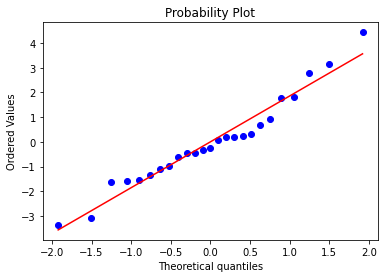

In [114]:
stats.probplot(modelo.resid, dist="norm", plot=plt)
plt.show()

In [115]:
stats.kstest(modelo.resid, stats.norm.cdf)

KstestResult(statistic=0.1635789669412665, pvalue=0.4666152820564231)

In [116]:
stats.anderson(modelo.resid)

AndersonResult(statistic=0.4152138817662703, critical_values=array([0.514, 0.586, 0.703, 0.82 , 0.975]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

De manera análoga al ejercico anterior, afirmamos que los residuales se distribuyen de manera normal basandonos en las pruebas de Kolmogorov y de Anderson

Prodecemos a verificar el supuesto de que si $i \not = j$, entonces $Cov(\varepsilon_i, \varepsilon_j) = 0$, para ello tenemos la prueba de Durbin-Watson. En este caso la estadística tomó el valor de 0.89, como dicho valor está fuera del intervalo $(1.5, 2.5)$, entonces empezamos a sospechar que hay problemas con la correlación.

Procedemos a verificar la homocedasticidad del modelo por medio del grafíco de los residuales contra las predicciones y usando la prueba de Brewn-Pagan 

[('Lagrange multiplier statistic', 9.088065875880828),
 ('p-value', 0.0025728281482536356),
 ('f-value', 13.136398976691332),
 ('f p-value', 0.0014223224065023634)]

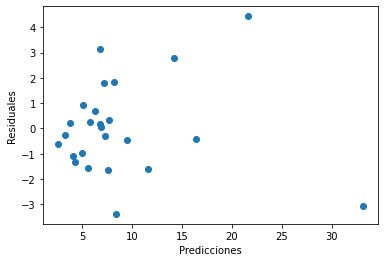

In [117]:
#Predicciones contra residuos (supuesto 3)
predict = modelo.predict(X)
plt.scatter(predict, modelo.resid)
plt.xlabel('Predicciones')
plt.ylabel('Residuales')

names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']

# Get the test result
test_result = sms.het_breuschpagan(modelo.resid, modelo.model.exog)

lzip(names, test_result)

El grafico claramente tiene un patron de acumulación en la parte izquiera, lo cual quiere decir que no hay homocedasticidad, lo cual confirma el test de Brewn-Pagan el cual arrojó un $p-value = 0.002$

Finalmente, para concluir que no hay mocedasticidad hacemos el diagrama de autocorrelación

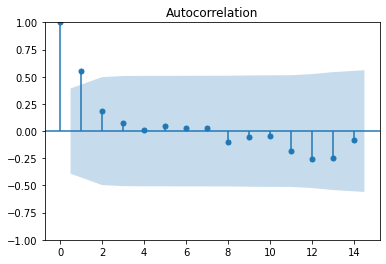

In [118]:
plot_acf(modelo.resid)
plt.show()

Como encontramos que hay una correlación (la segunda) que sale del intervalo de confianza graficado, entonces concluimos que el modelo no cumple la homocedasticidad

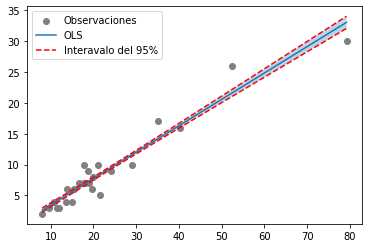

In [119]:
#obtenemos los valores de la regresion
predicciones = modelo.get_prediction(exog = X).summary_frame(alpha=0.5)
predicciones['x'] = X[:, 1]
predicciones['y'] = y
predicciones = predicciones.sort_values('x')

#graficamos las observaciones, la regresion y un intervalo del 95% de confianza
fig, ax = plt.subplots()

ax.scatter(predicciones['x'], predicciones['y'], marker='o', color = "gray", label = 'Observaciones')
ax.plot(predicciones['x'], predicciones["mean"], linestyle='-', label="OLS")
ax.plot(predicciones['x'], predicciones["mean_ci_lower"], linestyle='--', color='red', label="Interavalo del 95%")
ax.plot(predicciones['x'], predicciones["mean_ci_upper"], linestyle='--', color='red')
ax.fill_between(predicciones['x'], predicciones["mean_ci_lower"], predicciones["mean_ci_upper"], alpha=0.3)
ax.legend()

A pesar de que el valor de la $R^2$ es alto ($0.93$), el modelo no cumple la homocedasticidad, pero se sostiene el supuesto de que el tiempo que tarda un empleado está relacionado con el volúmen de refrescos. 

Veamos que pasa si quitamos los outliers, para ello vamos a calcular el indice de Cook

(array([3.36034029e-03, 1.22037571e-02, 1.70750285e-02, 1.92952305e-02,
       7.44922984e-03, 3.12314603e-05, 4.79932839e-03, 2.43007717e-04,
       5.10563872e+00, 7.25204600e-02, 3.19720047e-03, 2.13866391e-02,
       8.05790586e-03, 1.74106200e-02, 1.30044592e-03, 1.92668240e-02,
       4.78521724e-04, 6.52516870e-04, 7.26763189e-04, 8.94455778e-02,
       6.89415473e-02, 8.62909453e-01, 2.15899804e-02, 7.17765893e-04,
       4.83728926e-04]), array([0.99664579, 0.9878768 , 0.98308237, 0.98090559, 0.99258084,
       0.99996877, 0.99521317, 0.99975702, 0.01462467, 0.93025852,
       0.99680835, 0.97885988, 0.99197727, 0.98275301, 0.99870047,
       0.98093341, 0.9995216 , 0.99934771, 0.99927352, 0.91475453,
       0.93357337, 0.43514826, 0.97866122, 0.99928251, 0.9995164 ]))


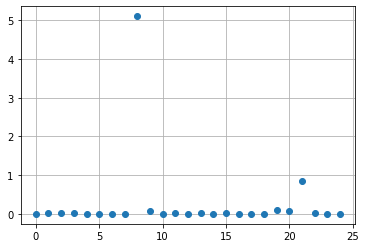

In [120]:
influence = modelo.get_influence()
cooks = influence.cooks_distance
#cooks contiene dos arrays, el primero con el indicie de cook y el segundo 
#con el p-value
print(cooks)

#graficamos el num de obs y su indice de cook
plt.plot([i for i in range(25)], cooks[0], 'o')
plt.grid()
# plt.ylim(-0.1, 0.2)

Vamos a eliminar aquellas observaciones con el indice de Cook muy alto, las cuales son las observaciones número 9 y 22 

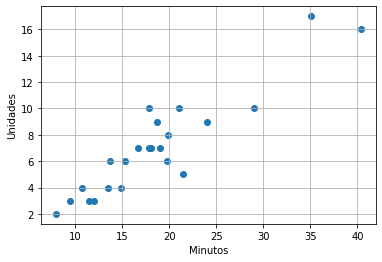

In [121]:
#eliminamos la obs 9 y 22
refrescos2 = refrescos.drop([8, 21])

#Dividimos los datos
X = np.array(refrescos2[0].values).reshape(-1, 1)
y = np.array(refrescos2[1].values).reshape(-1, 1)

#graficamos
plt.scatter(X, y)
plt.xlabel('Minutos')
plt.ylabel('Unidades')
plt.grid()
plt.show()

In [122]:
#instanciamos el modelo de regresion simple

X = sm.add_constant(X, prepend = True)
modelo = sm.OLS(endog = y, exog = X)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     118.4
Date:                Sun, 16 Apr 2023   Prob (F-statistic):           4.33e-10
Time:                        14:07:57   Log-Likelihood:                -41.283
No. Observations:                  23   AIC:                             86.57
Df Residuals:                      21   BIC:                             88.84
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3817      0.841     -1.643      0.1

Notamos que el valor de la $R^2$ bajó. Vamos a verificar rápidamente los supuestos

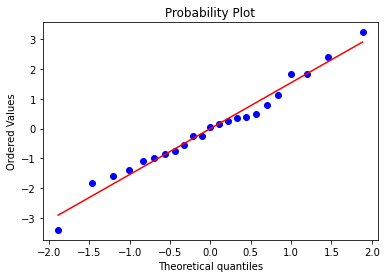

In [123]:
stats.probplot(modelo.resid, dist="norm", plot=plt)
plt.show()

In [124]:
stats.kstest(modelo.resid, stats.norm.cdf)

KstestResult(statistic=0.13996385278618217, pvalue=0.7071395463661572)

In [125]:
stats.anderson(modelo.resid)

AndersonResult(statistic=0.2076474306735676, critical_values=array([0.511, 0.582, 0.699, 0.815, 0.969]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Se cumple la normalidad de los residuales

[('Lagrange multiplier statistic', 1.8826479118512989),
 ('p-value', 0.17003350024761188),
 ('f-value', 1.8721857732847622),
 ('f p-value', 0.18568753631763393)]

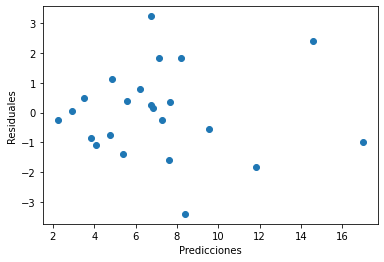

In [126]:
#Predicciones contra residuos (supuesto 3)
predict = modelo.predict(X)
plt.scatter(predict, modelo.resid)
plt.xlabel('Predicciones')
plt.ylabel('Residuales')

names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']

# Get the test result
test_result = sms.het_breuschpagan(modelo.resid, modelo.model.exog)

lzip(names, test_result)

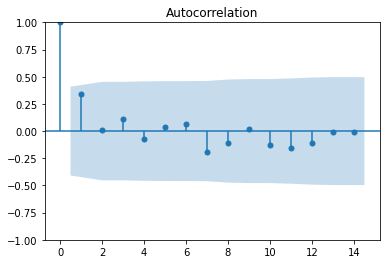

In [127]:
plot_acf(modelo.resid)
plt.show()

También se cumple la homocedasticidad

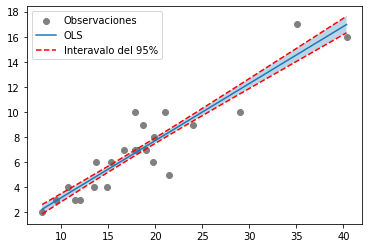

In [128]:
#obtenemos los valores de la regresion
predicciones = modelo.get_prediction(exog = X).summary_frame(alpha=0.5)
predicciones['x'] = X[:, 1]
predicciones['y'] = y
predicciones = predicciones.sort_values('x')

#graficamos las observaciones, la regresion y un intervalo del 95% de confianza
fig, ax = plt.subplots()

ax.scatter(predicciones['x'], predicciones['y'], marker='o', color = "gray", label = 'Observaciones')
ax.plot(predicciones['x'], predicciones["mean"], linestyle='-', label="OLS")
ax.plot(predicciones['x'], predicciones["mean_ci_lower"], linestyle='--', color='red', label="Interavalo del 95%")
ax.plot(predicciones['x'], predicciones["mean_ci_upper"], linestyle='--', color='red')
ax.fill_between(predicciones['x'], predicciones["mean_ci_lower"], predicciones["mean_ci_upper"], alpha=0.3)
ax.legend()

El segundo modelo, eliminando los dos outliers de la tienda 9 y 22, ya cumple los supuestos para la regresión lineal. 

La recomendación es tomar éste segundo modelo que, aunque explica en menor cantidad la variabilidad de los datos, es el más adecuado. 
Por lo tanto, sí hay relación entre el tiempo que le toma a un empleado hacer su trabajo con el volúmen de refrescos.